<a href="https://colab.research.google.com/github/gvogiatzis/CS4740/blob/main/CS4740_Lab_Week_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from collections import defaultdict
from random import choice,random, sample
import matplotlib.pyplot as plt
from math import cos
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import gym

actions = torch.tensor([-1,0,1])

def init_state():
    return torch.tensor([0.2*random()-0.6,0])

def epsilon_greedy(epsilon, S, qnet):
    if random() < epsilon:
        return torch.tensor(choice(range(qnet.num_actions)))
    else:
        return qnet(S).argmax()

def next_state_and_reward(s,a):
    A = actions[a]
    clamp = lambda x,u,v: min(max(u,x),v)
    position, velocity = s
    velocity = clamp(velocity + 0.001*A - 0.0025*cos(3*position), -0.07,0.07) 
    position = clamp(position + velocity, -1.2, 0.6)
    if (position == -1.2 and velocity < 0):
        velocity = 0
    return torch.tensor([position,velocity]), torch.tensor(-1)

def done(s):
    return s[0]>=0.5



class Qnet(nn.Module):
    def __init__(self, input_size,hidden_size,output_size):
        self.num_actions = output_size
        super(Qnet, self).__init__()        
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size,output_size)        
    def forward(self, x):        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class MLPnet(nn.Module):
    def __init__(self, *sizes):
        self.num_actions = sizes[-1]
        super(MLPnet, self).__init__()
        self.layers = nn.ModuleList()
        for s,s_ in zip(sizes[:-1],sizes[1:]):
            self.layers.append(nn.Linear(s,s_))
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [ ]:
env = gym.make("MountainCar-v0")
print(env._max_episode_steps)

200


In [ ]:
env.reset()
for i in range(200):
    _,_,done,_ = env.step(1)
    print(done)

In [ ]:
start_e = 1.0
end_e = 0.05
expl_fraction = 0.8

def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    slope =  (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)

1 19753


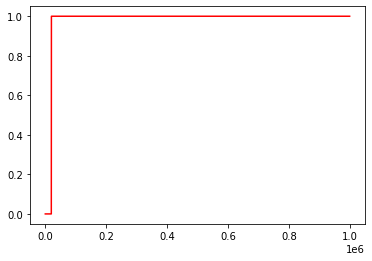

In [ ]:
qnet = MLPnet(2,120,84,3)
env = gym.make("MountainCar-v0").env
env.reset()

# replaybuffer = deque(maxlen=10000)

# optim = torch.optim.SGD(qnet.parameters(),lr=0.001)
optim = torch.optim.Adam(qnet.parameters())
loss = torch.nn.MSELoss()

batchsize=64
S = torch.tensor(env.reset(),dtype=torch.float)
# S=init_state()
episodes=0
E=[]
rewards=[]
tot_reward=0
durations=[]
duration = 0
MAX_TIMESTEPS = 1000000
done = False
for t in range(1000000):
    # if done(S):# or duration==200:
    if done:# or duration==200:
        done = False
        S = torch.tensor(env.reset(),dtype=torch.float)
        # S=init_state()
        episodes+=1
        print(episodes,duration)
        duration=0
        rewards.append(tot_reward)
        tot_reward=0
    epsilon = linear_schedule(start_e, end_e, expl_fraction*MAX_TIMESTEPS, t)
    A = epsilon_greedy(epsilon, S, qnet)
    S_new, R, done, _ = env.step(A.numpy())
    S_new,R = map(lambda x:torch.tensor(x,dtype=torch.float),(S_new, R))
    # S_new,R = next_state_and_reward(S,A)

    # replaybuffer.append((S,A,R,S_new))
    
    duration +=1
    tot_reward += R
    qval = qnet(S)[A]
    qval_target = R + qnet(S_new).max()
    L = loss(qval,qval_target)
    optim.zero_grad()
    L.backward()
    optim.step()
    # if(len(replaybuffer)>=batchsize):
    #     s,a,r,s_new=map(torch.stack,zip(*sample(replaybuffer,10)))
    #     qval=qnet(s).gather(1,a.unsqueeze(-1)).squeeze()
    #     target= r + torch.max(qnet(s_new),dim=1)[0]
    #     L = loss(qval,target)
    #     optim.zero_grad()
    #     L.backward()
    #     optim.step()
    # Q[S,A] = (1-alpha) * Q[S,A] + alpha * target
    
    S = S_new
    E.append(episodes)
plt.plot(E,'r-')

In [ ]:
qnet(S)

RuntimeError: ignored

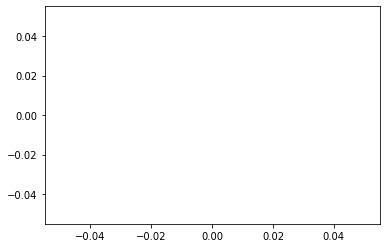

In [ ]:
plt.plot(E,'r-')

In [ ]:
qnet = Qnet(2,100,3)

replaybuffer = deque(maxlen=10000)

optim = torch.optim.SGD(qnet.parameters(),lr=0.001)
loss = torch.nn.MSELoss()

batchsize=64
S = init_state()
episodes=0
E=[]
rewards=[]
tot_reward=0

for t in range(1000000):
    if done(S):
        episodes+=1
        rewards.append(tot_reward)
        tot_reward=0
        S=init_state()
        print(episodes)
    A = epsilon_greedy(0.2, S, qnet)
    S_new,R = next_state_and_reward(S,A)
    replaybuffer.append((S,A,R,S_new))
    
    tot_reward += R        
    target = R + qnet(S_new).max()
    
    if(len(replaybuffer)>=batchsize):
        s,a,r,s_new=map(torch.stack,zip(*sample(replaybuffer,10)))
        qval=qnet(s).gather(1,a.unsqueeze(-1)).squeeze()
        target= r + torch.max(qnet(s_new),dim=1)[0]
        L = loss(qval,target)
        optim.zero_grad()
        L.backward()
        optim.step()
    # Q[S,A] = (1-alpha) * Q[S,A] + alpha * target
    
    S = S_new
    E.append(episodes)
plt.plot(E,'r-')

1177
1178
1179
1180


KeyboardInterrupt: ignored

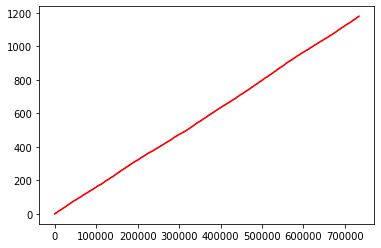

In [ ]:
plt.plot(E,'r-')